In [1]:
%load_ext autoreload
%autoreload 2

## 1. Dataset

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import helpers.pytorch_utils as ptu

from PIL import Image
from torchvision.transforms import PILToTensor
from helpers.models import FoodDataset

In [3]:
filename = "data/food/00000.jpg"
img = Image.open(filename)
img_array = np.asarray(img)
img_array.shape, img_array.dtype

((324, 464, 3), dtype('uint8'))

In [4]:
np.histogram(img_array)

(array([49904, 60236, 60893, 53720, 59924, 61158, 53531, 29985, 16047,
         5610], dtype=int64),
 array([  0. ,  25.5,  51. ,  76.5, 102. , 127.5, 153. , 178.5, 204. ,
        229.5, 255. ]))

In [5]:
img_tensor = PILToTensor()(img)
img_tensor = (img_tensor / 255.).to(torch.float32)
img_tensor.max(), img_tensor.dtype

(tensor(1.), torch.float32)

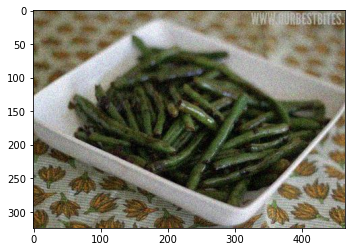

In [6]:
plt.imshow(ptu.to_numpy(img_tensor.permute(1, 2, 0)))

In [7]:
train_filename = "./data/train_triplets.txt"
food_dataset = FoodDataset(train_filename, mode="test")

In [8]:
len(food_dataset)

59515

In [9]:
index = 0
img1, img2, img3 = food_dataset[index]
img1.shape, img2.shape, img3.shape

(torch.Size([3, 224, 224]),
 torch.Size([3, 224, 224]),
 torch.Size([3, 224, 224]))

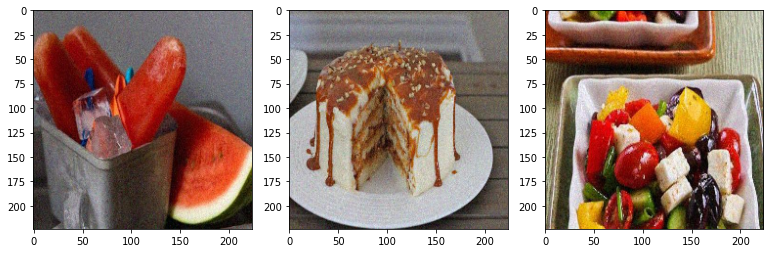

In [10]:
food_dataset.visualize_imgs([img1, img2, img3])

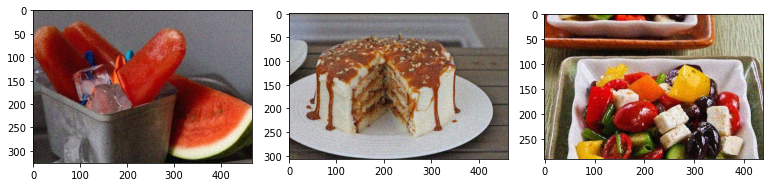

In [11]:
food_dataset.visualize_imgs(food_dataset.get_orig_imgs(index), mode="train")

## 2. Model

In [2]:
import torch
import helpers.configs as configs
import helpers.pytorch_utils as ptu

from helpers.models import FoodTaster, predict

In [3]:
model_args = configs.configs_food_taster_param
food_taster = FoodTaster(model_args).to(ptu.ptu_device)

Using cache found in C:\Users\lenovo/.cache\torch\hub\pytorch_vision_v0.10.0


In [14]:
B, C, H, W = 2, 3, 300, 400
X_test = torch.randn(B, C, H, W).to(ptu.ptu_device)
X_test_out = food_taster(X_test)
X_test_out.shape, torch.allclose((X_test_out ** 2).sum(dim=1), torch.tensor(1.))

(torch.Size([2, 128]), True)

In [15]:
num_features = 128
X_feat1, X_feat2, X_feat3 = [torch.randn(B, C, H, W).to(ptu.ptu_device) for _ in range(3)]
pred_binary = predict(food_taster, (X_feat1, X_feat2, X_feat3))
pred_binary

array([0, 0])

## 3. Training

In [2]:
import time
import helpers.configs as configs
import helpers.pytorch_utils as ptu

from torch.utils.data import DataLoader
from helpers.models import FoodDataset, FoodTaster
from helpers.trainer import FoodTasterTrainer

In [3]:
time_stamp = f"{time.time()}".replace(".", "_")

# bash params
all_params = {
    "batch_size": 64,
    "epochs": 5,
    "log_dir": f"run/food_taster/{time_stamp}",
    "param_save_dir": f"params/food_taster/{time_stamp}",
    "if_notebook": True,
    "train_filename": "data/train_triplets.txt",
    "test_filename": "data/test_triplets.txt"
}

all_params.update(configs.configs_trainer_param)
all_params.update(configs.configs_food_taster_param)
all_params

{'batch_size': 64,
 'epochs': 5,
 'log_dir': 'run/food_taster/1650953858_6676152',
 'param_save_dir': 'params/food_taster/1650953858_6676152',
 'if_notebook': True,
 'train_filename': 'data/train_triplets.txt',
 'test_filename': 'data/test_triplets.txt',
 'opt_args': {'class': torch.optim.adamw.AdamW, 'args': {'lr': 0.005}},
 'alpha': 1,
 'resnet_name': 'resnet18',
 'feature_dim': 128}

In [4]:
train_dataset = FoodDataset(all_params["train_filename"], mode="train")
eval_dataset = FoodDataset(all_params["train_filename"], mode="val")
test_dataset = FoodDataset(all_params["test_filename"], mode="test")

In [5]:
train_loader = DataLoader(train_dataset, batch_size=all_params["batch_size"], shuffle=True)
eval_loader = DataLoader(eval_dataset, batch_size=all_params["batch_size"])
test_loader = DataLoader(test_dataset, batch_size=all_params["batch_size"])

In [6]:
food_taster = FoodTaster(all_params).to(ptu.ptu_device)

Using cache found in C:\Users\lenovo/.cache\torch\hub\pytorch_vision_v0.10.0


In [7]:
trainer = FoodTasterTrainer(food_taster, train_loader, eval_loader, all_params)

In [9]:
# trainer.train()